### Imports and config

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

%config InlineBackend.figure_format='retina'

### Read data

In [2]:
df = pd.read_csv('../dataset/data.csv')

### Constants

In [3]:
# Ethnicity labels
ETHNICITIES = { 
    0: 'White', 
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Other'
}

# Gender labels
GENDERS = { 
    0: 'Male', 
    1: 'Female'
}

REVERSE_GENDERS = {
    'Male' : 0,
    'Female' : 1
}

#Image size
img_size = 48

### Utils

In [4]:
def render_row(row):
    pixels = bytearray([int(px) for px in row['pixels'].split(' ')])
    img = Image.frombytes('L', (img_size, img_size), bytes(pixels))
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2, 2), dpi=100)
    axes.axis('off')
    imgplot = plt.imshow(img, cmap='gray')
    x_offset_text = 52
    plt.text(x_offset_text, 5, 'Age: ' + str(row['age']))
    plt.text(x_offset_text, 12, 'Ethnicity: ' + ETHNICITIES[row['ethnicity']])
    plt.text(x_offset_text, 19, 'Gender: ' + GENDERS[row['gender']])
    plt.show()
#render_row(df.loc[0])

### Create balanced dataset

In [5]:
df['ethnicity'] = df['ethnicity'].map(ETHNICITIES)
df['gender'] = df['gender'].map(GENDERS)

In [6]:
#Ethnicity sample size
ethnicity_gender_sample_size = 100
age_filter = (df['age'] >= 20) & (df['age'] <= 40)
def ethnicity_gender_filter(df, i, j):
    return (df['ethnicity'] == ETHNICITIES[i]) & (df['gender'] == GENDERS[j])

df_age_filter = df[age_filter][['age', 'ethnicity', 'gender', 'pixels']]
w_df = df_age_filter.loc[ethnicity_gender_filter(df_age_filter, 0, 0)]\
        .sample(ethnicity_gender_sample_size, random_state=19)
balanced_df = pd.concat([
    df_age_filter.loc[ethnicity_gender_filter(df_age_filter, i, j)]\
        .sample(ethnicity_gender_sample_size, random_state=19)
    for i in range(len(ETHNICITIES))
    for j in range(len(GENDERS))
])

In [7]:
def print_summary(dataset):
    n_bins = 10
    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(12, 3))
    axs[0].title.set_text('Age')
    axs[0].hist(dataset['age'], bins=n_bins)
    axs[1].title.set_text('Ethnicity')
    axs[1].hist(dataset['ethnicity'], bins=5*2-1)
    axs[2].title.set_text('Gender')
    axs[2].hist(dataset['gender'], bins=2*2-1)
    print(f'Number of records: {len(dataset)}')

Number of records: 1000


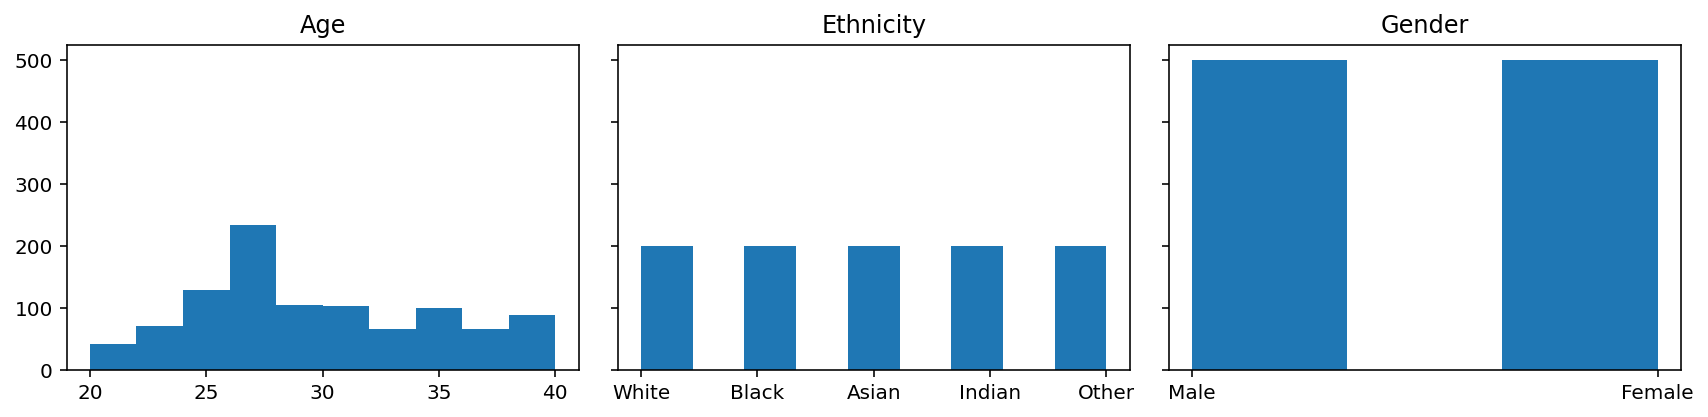

In [8]:
print_summary(balanced_df)

### Create Train - Test

In [9]:
balanced_df['pixels'] = balanced_df['pixels']\
        .apply(lambda x: np.array(x.split(), dtype='float32'))

X = np.array(balanced_df['pixels'].tolist())
X = np.reshape(X, (-1, 48, 48, 1))
y = balanced_df['gender'].map(REVERSE_GENDERS)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

## Tensorflow

### Generate ANN input

In [10]:
train_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

train_generator_gender = train_datagen.flow(
    X_train, y_train, batch_size=32
)

test_generator_gender = test_datagen.flow(
    X_test, y_test, batch_size=32
)

### Set stop condition

In [11]:
earlystop = EarlyStopping(patience=6)
learning_rate_reduction=ReduceLROnPlateau(
    patience= 3,
    verbose=1,
)
callbacks = [earlystop, learning_rate_reduction]

### Model

In [12]:
model_gender = Sequential()

model_gender.add(Conv2D(32, (3, 3),activation='relu', input_shape=(48, 48, 1)))
model_gender.add(MaxPooling2D(2, 2))

model_gender.add(Conv2D(64,(3,3),activation='relu'))
model_gender.add(MaxPooling2D(2,2))

model_gender.add(Flatten())
model_gender.add(Dense(1, activation='sigmoid'))

model_gender.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

model_gender.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [13]:
model_gender.fit(
    train_generator_gender, 
    epochs= 20,
    validation_data = test_generator_gender,
    callbacks= callbacks
)

Epoch 1/20
25/25 [==============================] - 2s 74ms/step - loss: 0.6651 - accuracy: 0.5962 - val_loss: 0.6678 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 2/20
25/25 [==============================] - 2s 82ms/step - loss: 0.5952 - accuracy: 0.6812 - val_loss: 0.5992 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 3/20
25/25 [==============================] - 2s 72ms/step - loss: 0.5537 - accuracy: 0.7250 - val_loss: 0.5598 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 4/20
25/25 [==============================] - 2s 81ms/step - loss: 0.4960 - accuracy: 0.7825 - val_loss: 0.4738 - val_accuracy: 0.8050 - lr: 0.0010
Epoch 5/20
25/25 [==============================] - 2s 68ms/step - loss: 0.4318 - accuracy: 0.8213 - val_loss: 0.4262 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 6/20
25/25 [==============================] - 1s 58ms/step - loss: 0.3826 - accuracy: 0.8475 - val_loss: 0.3687 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 7/20
25/25 [==============================] - 2s 68ms/step - loss: 0.3

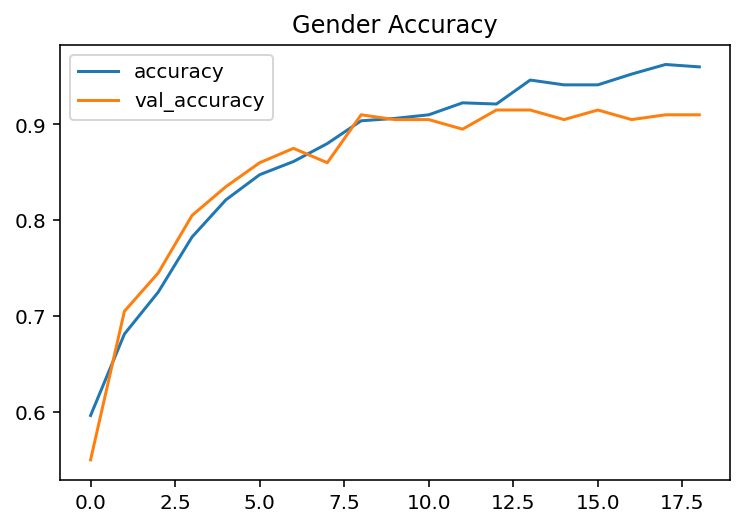

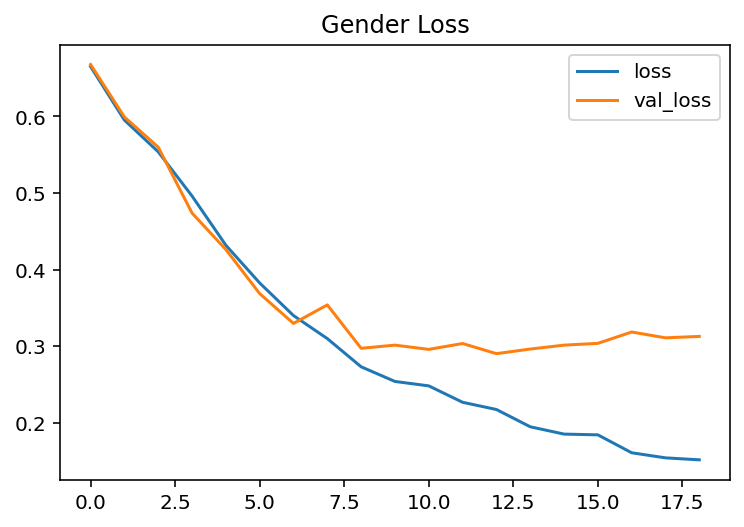

In [14]:
losses_gender = pd.DataFrame(model_gender.history.history)
losses_gender[['accuracy', 'val_accuracy']].plot(title='Gender Accuracy')
losses_gender[['loss', 'val_loss']].plot(title='Gender Loss')
plt.show()

### Evaluate TensorFlow CNN Model

In [15]:
y_tf_pred = np.rint(model_gender.predict(X_test))
f1_score(y_test, y_tf_pred)

0.8947368421052632

## Custom AdalineSGD

### Model

In [16]:
from numpy.random import seed
class AdalineSGD(object):
    def __init__(self, eta=0.01, n_iter=20,
        shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
            
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return self.net_input(X)
    
    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, 0)

### Data Preparation

In [17]:
X_ada_train = X_train.reshape(len(X_train), 48*48, )/255
y_ada_train = y_train
X_ada_test = X_test.reshape(len(X_test), 48*48, )/255
y_ada_test = y_test

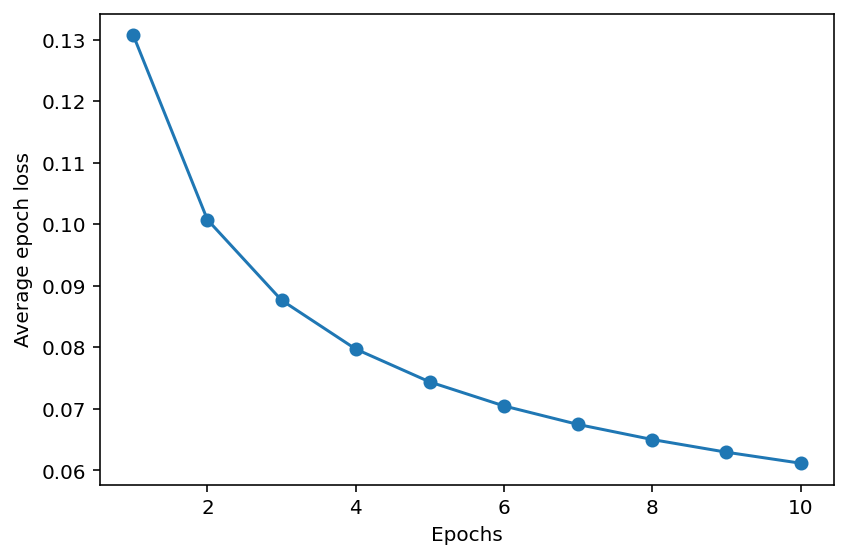

In [18]:
ada_sgd = AdalineSGD(eta=0.001, n_iter=10, shuffle=False, random_state=19)
ada_sgd.fit(X_ada_train, y_ada_train)
plt.plot(
    range(1, len(ada_sgd.cost_) + 1),
    ada_sgd.cost_, marker='o'
        )
plt.xlabel('Epochs')
plt.ylabel('Average epoch loss')
plt.tight_layout()
plt.show()

In [19]:
y_ada_pred = ada_sgd.predict(X_ada_test)

### Evaluate AdalineSGD

In [20]:
f1_score(y_ada_test, y_ada_pred)

0.7755102040816326